In [1]:
#importing necessary functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, substring, when, concat, lit
import pandas as pd
import geopandas as gpd
import osmnx as ox
import contextily as cx
import sklearn
from sklearn import cluster
from sklearn.cluster import KMeans
import numpy
import shapely
import matplotlib.pyplot as plt
import statistics
from statistics import mode
import json
import os
import pickle
from datetime import timedelta
from math import floor, ceil
import fiona
from pyproj import Proj
from shapely import geometry
from scipy.stats import poisson
from random import randint, uniform
from datetime import datetime
from operator import itemgetter
from copy import deepcopy
import csv
# import from the codebase
#from extract_regions import get_special_cells, special_time_checker

In [2]:
#finding the closest center to each point
def find_closest_center(centers, x, y):
    closest_center = -1
    cc_dist = 10000
    for i in range(len(centers)):
        dist = (centers[i][0]-x)**2 + (centers[i][1]-y)**2
        if dist<cc_dist:
            closest_center = i
            cc_dist = dist
    return closest_center

In [3]:
#finding which cluster contains the largest number of points in a given cell
def cell_voting(cell_points):
    if len(cell_points) == 0:
        return -1
    return(mode(cell_points))
            

In [4]:
def load_fire_stations(city):
    national_fire = gpd.read_file("/Users/hunter7lee/Downloads/Fire_Stations.geojson")
    local_fire = national_fire[national_fire["CITY"] == city]
    lon_array_temp = local_fire['geometry'].x.to_numpy()
    lat_array_temp = local_fire['geometry'].y.to_numpy()
    local_array = numpy.vstack((lon_array_temp, lat_array_temp)).T
    local_list = local_array.tolist()
    df_wm = local_fire.set_crs(crs='EPSG:4326', allow_override=True)
    ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
    cx.add_basemap(ax, crs=df_wm.crs.to_string())
    
        
    return local_array
    

In [ ]:
fire_array = load_fire_stations("Seattle")
fire_array[:, [1, 0]] = fire_array[:, [0, 1]]
fire_array = fire_array.T

In [ ]:
print(fire_array)

In [4]:
#reading data from the created file
data = gpd.read_file("/Users/hunter7lee/Desktop/ISIS/SeattleData192021.geojson")

In [5]:
#creating the array of points from the data set
lon_array = data['lon'].to_numpy()
lat_array = data['lat'].to_numpy()
point_array = numpy.vstack((lon_array, lat_array)).T
print(len(point_array))

20197


In [6]:
#doing kmeans with n_clusters clusters
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(point_array)
#defining the labels and the cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_
#creating the bounds of the data
xmin, ymin, xmax, ymax= data.total_bounds

In [ ]:
print(data.total_bounds)

In [7]:
#distance from xmin to xmax is approximately 8.7 miles, looking for one mile cells
length_cells=8.7
cell_size = (xmax-xmin)/length_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
grid_cells = []
for x0 in numpy.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in numpy.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)
# adapted from https://james-brennan.github.io/posts/fast_gridding_geopandas/

In [9]:
#creating a dictionary that relates an integer to each of the cells
cell_dict = {}
i=0

for c in grid_cells:
    
    cell_dict[i] = c
    i += 1


In [13]:
#print(cell_dict)

{0: <shapely.geometry.polygon.Polygon object at 0x175004d60>, 1: <shapely.geometry.polygon.Polygon object at 0x1750073a0>, 2: <shapely.geometry.polygon.Polygon object at 0x175007850>, 3: <shapely.geometry.polygon.Polygon object at 0x175005780>, 4: <shapely.geometry.polygon.Polygon object at 0x175007b50>, 5: <shapely.geometry.polygon.Polygon object at 0x175007c70>, 6: <shapely.geometry.polygon.Polygon object at 0x1750044f0>, 7: <shapely.geometry.polygon.Polygon object at 0x175004550>, 8: <shapely.geometry.polygon.Polygon object at 0x175004370>, 9: <shapely.geometry.polygon.Polygon object at 0x175004520>, 10: <shapely.geometry.polygon.Polygon object at 0x175004310>, 11: <shapely.geometry.polygon.Polygon object at 0x1750044c0>, 12: <shapely.geometry.polygon.Polygon object at 0x175004580>, 13: <shapely.geometry.polygon.Polygon object at 0x175005f00>, 14: <shapely.geometry.polygon.Polygon object at 0x175007730>, 15: <shapely.geometry.polygon.Polygon object at 0x1750074f0>, 16: <shapely.geom

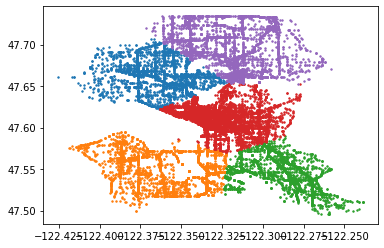

In [10]:
#fit_predict allows us to print the clustered data
label = kmeans.fit_predict(point_array)
u_labels = numpy.unique(label)
# for i in u_labels:
#     plt.scatter(point_array[label==i, 0], point_array[label==i, 1], label = i, s = 2)
# ax = plt
#transposing so centers[0] and centers[1] call the x and y coordinates
centers = centers.T

(-122.43463330967757,
 -122.22963110917993,
 47.48408176206495,
 47.74604918521363)

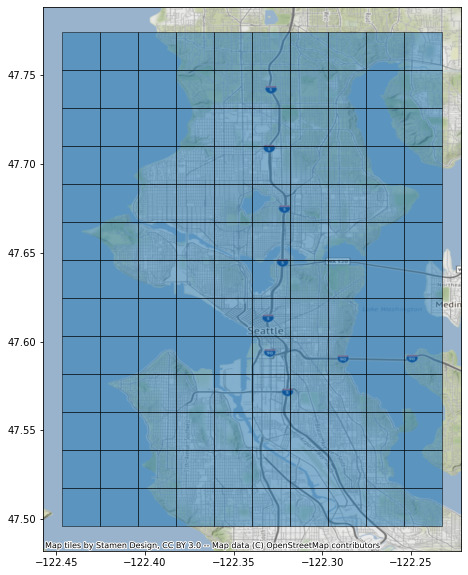

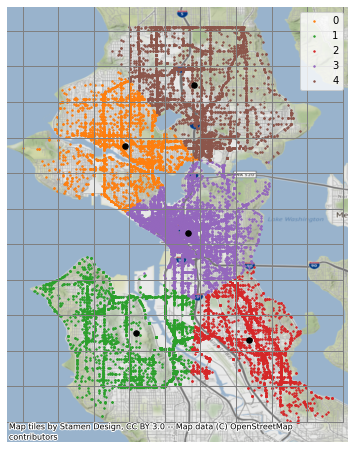

In [11]:
#creating the background map
# df_wm = cell.set_crs(crs='EPSG:4326', allow_override=True)
# ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
# cx.add_basemap(ax, crs=df_wm.crs.to_string())
# ax = data.plot(markersize=.1, figsize=(12, 8))
# #creating a scatter plot of the data points
# for i in u_labels:
#     plt.scatter(point_array[label==i, 0], point_array[label==i, 1], label = i, s = 2)
# #adding the cluster centers
# plt.scatter(centers[0], centers[1], s = 30, c="black")
# plt.autoscale(False)
# plt.legend()
# #plotting the data points and cluster centers
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# cx.add_basemap(ax, crs=df_wm.crs.to_string())
# ax.axis("off")

In [12]:
#creating a list of lists, where the exterior list has a list of cells, and the interior list
#has a list of every point in each cell
point_array = point_array.T
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(point_array[0], point_array[1]))
points = gpd.GeoSeries(gpd.points_from_xy(point_array[0], point_array[1]), crs='EPSG:4326')
counter = 0
all_cells = []
print(centers)
centers = centers.T
for c in grid_cells:
    cellab = []
    i=0
    for p in points:
        if c.contains(p):
            cellab.append(find_closest_center(centers, p.x, p.y))
            
    all_cells.append(cellab)
    

[[-122.36387087 -122.35688114 -122.28874834 -122.32573984 -122.32201559]
 [  47.66255939   47.54971355   47.54519474   47.6097813    47.69886696]]


In [13]:
#doing the cell voting, creating a list of num_celss length where each value is the cluster that cell belongs to
cell_values = []
num_cells_incident = 0
total_incidents = 0
for c in all_cells:
    total_incidents += len(c)
    print(c)
    x = cell_voting(c)
    cell_values.append(x)
    if x!= -1:
        num_cells_incident += 1
        
cell_values_dict = {}
for i in range(len(cell_values)):
    cell_values_dict[i] = cell_values[i]
    
#with open("/Users/hunter7lee/Desktop/Seattle/1x1/eightClusters/kMeansClusters.pkl", 'wb') as f:
    #pickle.dump((cell_values_dict, kmeans), f)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1]
[]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[]
[]
[]
[]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
print(cell_values_dict)

{0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: 1, 17: 1, 18: -1, 19: 0, 20: 0, 21: 0, 22: -1, 23: -1, 24: -1, 25: -1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: -1, 32: 0, 33: 0, 34: 0, 35: 0, 36: -1, 37: -1, 38: -1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 3, 45: 0, 46: 0, 47: 0, 48: 0, 49: 4, 50: 4, 51: -1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 3, 58: 3, 59: 0, 60: 0, 61: 4, 62: 4, 63: 4, 64: -1, 65: -1, 66: 1, 67: 1, 68: 1, 69: 3, 70: 3, 71: 3, 72: 4, 73: 4, 74: 4, 75: 4, 76: 4, 77: -1, 78: -1, 79: 2, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 4, 86: 4, 87: 4, 88: 4, 89: 4, 90: -1, 91: 2, 92: 2, 93: 2, 94: 2, 95: 3, 96: 3, 97: 3, 98: 4, 99: 4, 100: 4, 101: 4, 102: 4, 103: -1, 104: 2, 105: 2, 106: 2, 107: 2, 108: -1, 109: -1, 110: -1, 111: 4, 112: 4, 113: 4, 114: -1, 115: -1, 116: -1, 117: 2, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: -1, 125: -1, 126: -1, 127: -1, 128: -1, 129: -1}


In [15]:
i=0
cell_dict_full = cell_values_dict.copy()
print(cell_dict_full)
for key, value in cell_dict_full.items():
    if value == -1:
        print("deleting")
        del cell_dict[i]
    i+= 1

{0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: 1, 17: 1, 18: -1, 19: 0, 20: 0, 21: 0, 22: -1, 23: -1, 24: -1, 25: -1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: -1, 32: 0, 33: 0, 34: 0, 35: 0, 36: -1, 37: -1, 38: -1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 3, 45: 0, 46: 0, 47: 0, 48: 0, 49: 4, 50: 4, 51: -1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 3, 58: 3, 59: 0, 60: 0, 61: 4, 62: 4, 63: 4, 64: -1, 65: -1, 66: 1, 67: 1, 68: 1, 69: 3, 70: 3, 71: 3, 72: 4, 73: 4, 74: 4, 75: 4, 76: 4, 77: -1, 78: -1, 79: 2, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 4, 86: 4, 87: 4, 88: 4, 89: 4, 90: -1, 91: 2, 92: 2, 93: 2, 94: 2, 95: 3, 96: 3, 97: 3, 98: 4, 99: 4, 100: 4, 101: 4, 102: 4, 103: -1, 104: 2, 105: 2, 106: 2, 107: 2, 108: -1, 109: -1, 110: -1, 111: 4, 112: 4, 113: 4, 114: -1, 115: -1, 116: -1, 117: 2, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: -1, 125: -1, 126: -1, 127: -1, 128: -1, 129: -1}
deleting
deleting
d

In [16]:
print(cell_dict)

{16: <shapely.geometry.polygon.Polygon object at 0x179a89210>, 17: <shapely.geometry.polygon.Polygon object at 0x179a89120>, 19: <shapely.geometry.polygon.Polygon object at 0x179a89060>, 20: <shapely.geometry.polygon.Polygon object at 0x179a89000>, 21: <shapely.geometry.polygon.Polygon object at 0x179a88190>, 26: <shapely.geometry.polygon.Polygon object at 0x179a8a2f0>, 27: <shapely.geometry.polygon.Polygon object at 0x179a88a00>, 28: <shapely.geometry.polygon.Polygon object at 0x179a885e0>, 29: <shapely.geometry.polygon.Polygon object at 0x179a88bb0>, 30: <shapely.geometry.polygon.Polygon object at 0x179a88310>, 32: <shapely.geometry.polygon.Polygon object at 0x179a88250>, 33: <shapely.geometry.polygon.Polygon object at 0x179a881f0>, 34: <shapely.geometry.polygon.Polygon object at 0x179a886a0>, 35: <shapely.geometry.polygon.Polygon object at 0x179a88040>, 39: <shapely.geometry.polygon.Polygon object at 0x179a8a1d0>, 40: <shapely.geometry.polygon.Polygon object at 0x179a884c0>, 41: <sh

In [21]:
from shapely.geometry import Point
place = "Seattle, Washington, USA"
G = ox.graph_from_place(place, network_type="drive")
Gp = ox.project_graph(G, to_crs='epsg:4326')
cell_centers_dict = {}
for key, value in cell_dict.items():
    p1, p2, p3, p4 = value.bounds
    c1 = (p1 + p3) / 2
    c2 = (p2 + p4) / 2
    print(c1, " ", c2)
    node, dist = ox.nearest_nodes(Gp, c1, c2, return_dist = True)
    cell_centers_dict[key] = node
    print(dist)
print( cell_centers_dict)  

-122.41995969344549   47.57631938807704
13.705274792337178
-122.41995969344549   47.662004738337274
406.44964680135297
-122.40924902466296   47.56560871929452
89.61633408948379
-122.40924902466296   47.57631938807704
48.93603552126186
-122.40924902466296   47.587030056859575
704.0937497810435
-122.40924902466296   47.640583400772215
24.568964812626938
-122.40924902466296   47.65129406955475
93.66047494628243
-122.40924902466296   47.662004738337274
124.62159211614478
-122.40924902466296   47.67271540711981
181.31306876549473
-122.40924902466296   47.68342607590233
610.0610916555977
-122.39853835588042   47.5227660441644
160.3115818836102
-122.39853835588042   47.53347671294692
440.9861161142148
-122.39853835588042   47.54418738172946
157.95961035640863
-122.39853835588042   47.55489805051198
68.17167019844734
-122.39853835588042   47.56560871929452
89.89139373271422
-122.39853835588042   47.57631938807704
84.18164424256183
-122.39853835588042   47.587030056859575
210.15399334852188
-12

91.10449386518154
-122.32356367440266   47.55489805051198
124.89226906107197
-122.32356367440266   47.56560871929452
30.383932347735804
-122.32356367440266   47.57631938807704
156.35890839529384
-122.32356367440266   47.587030056859575
91.64847947348568
-122.32356367440266   47.5977407256421
28.390816554492872
-122.32356367440266   47.608451394424634
53.26424707403968
-122.32356367440266   47.619162063207156
65.53073530308392
-122.32356367440266   47.62987273198969
109.61526159188973
-122.32356367440266   47.640583400772215
95.16604471109677
-122.32356367440266   47.65129406955475
140.41235110781037
-122.32356367440266   47.662004738337274
52.50153443282208
-122.32356367440266   47.67271540711981
51.83861731626384
-122.32356367440266   47.68342607590233
19.2375114093891
-122.32356367440266   47.69413674468487
40.273001499296754
-122.32356367440266   47.70484741346739
30.66851974219986
-122.32356367440266   47.71555808224993
32.990235076822785
-122.32356367440266   47.72626875103245
152

In [ ]:
import osmnx as ox
travel_time_dict = {}
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
for key1, value1 in cell_centers_dict.items():
    one_key_dict = {}
    for key2, value2 in cell_centers_dict.items():
        time = 0
        if(value1 != value2):
            route = ox.shortest_path(G, value1, value2, weight="travel_time")
            if route is not None:
                time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "travel_time")))
            else:
                time = 1000000
        one_key_dict["cell_id_" + str(key2)] = time
    travel_time_dict["cell_id_" + str(key1)] = one_key_dict
    print(finishe)
print(travel_time_dict)
    

In [ ]:
print("fun")

In [25]:
with open('/Users/hunter7lee/Desktop/Seattle/halfxhalf/travel_time_matrix5x5.pkl', 'wb') as handle:
    pickle.dump(travel_time_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
with open('/Users/hunter7lee/Desktop/Seattle/1x1/travel_time_matrix1x1.pkl', 'rb') as handle:
    b = pickle.load(handle)

In [27]:
print(b)

{'cell_id_16': {'cell_id_16': 0, 'cell_id_17': 187, 'cell_id_19': 1612, 'cell_id_20': 1570, 'cell_id_21': 1577, 'cell_id_26': 702, 'cell_id_27': 484, 'cell_id_28': 294, 'cell_id_29': 170, 'cell_id_30': 282, 'cell_id_32': 1262, 'cell_id_33': 1431, 'cell_id_34': 1509, 'cell_id_35': 1655, 'cell_id_39': 827, 'cell_id_40': 625, 'cell_id_41': 452, 'cell_id_42': 391, 'cell_id_43': 381, 'cell_id_44': 1011, 'cell_id_45': 1121, 'cell_id_46': 1186, 'cell_id_47': 1366, 'cell_id_48': 1521, 'cell_id_49': 1622, 'cell_id_50': 1772, 'cell_id_52': 826, 'cell_id_53': 772, 'cell_id_54': 619, 'cell_id_55': 550, 'cell_id_56': 736, 'cell_id_57': 896, 'cell_id_58': 1010, 'cell_id_59': 1075, 'cell_id_60': 1217, 'cell_id_61': 1363, 'cell_id_62': 1466, 'cell_id_63': 1454, 'cell_id_66': 904, 'cell_id_67': 730, 'cell_id_68': 562, 'cell_id_69': 735, 'cell_id_70': 855, 'cell_id_71': 965, 'cell_id_72': 1071, 'cell_id_73': 1150, 'cell_id_74': 1154, 'cell_id_75': 1361, 'cell_id_76': 1351, 'cell_id_79': 1014, 'cell_id_8

In [17]:
valid_cells = list(cell_dict.keys())

In [18]:
cell["kmeanGroup"] = cell_values
num_cells = len(cell_values)

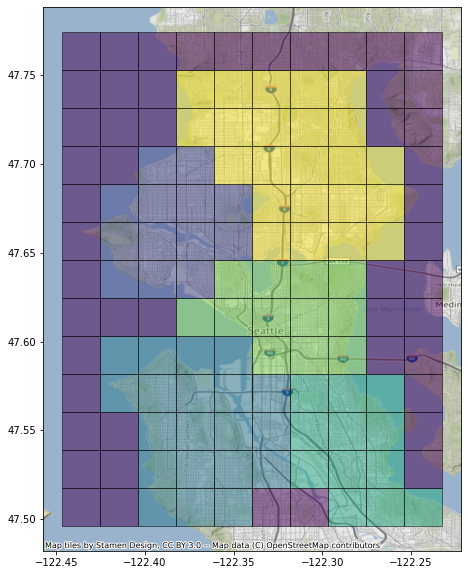

In [21]:
#creating map using the cells
df_wm = cell.set_crs(crs='EPSG:4326', allow_override=True)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', column = "kmeanGroup")
cx.add_basemap(ax, crs=df_wm.crs.to_string())
plt.scatter(centers[0], centers[1], s = 30, c="black")

In [22]:
#printing information
print("Total incidents: " , total_incidents)
print("Total cells: " , num_cells)
print("Total cells with incident: " , num_cells_incident)
print("Range of Data: January 1st, 2019 - December 31st, 2021")


Total incidents:  20193
Total cells:  130
Total cells with incident:  80
Range of Data: January 1st, 2019 - December 31st, 2021


In [16]:
hospitals = gpd.read_file("/Users/hunter7lee/Downloads/Hospitals.geojson")
#data from https://hifld-geoplatform.opendata.arcgis.com/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0/explore?location=47.607153%2C-122.247132%2C10.93
hospitals_simp = hospitals[["NAME", "ADDRESS", "CITY", "STATE", "ZIP", "geometry"]]
hospitals_simp = hospitals_simp.assign(latitude = (hospitals_simp['geometry'].x.to_numpy()) ,  longitude = (hospitals_simp['geometry'].y.to_numpy()), cell_id = -1)


In [17]:

print(hospitalsSEA)

NameError: name 'hospitalsSEA' is not defined

In [18]:
df_wm = hospitalsSEA.set_crs(crs='EPSG:4326', allow_override=True)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, crs=df_wm.crs.to_string())

NameError: name 'hospitalsSEA' is not defined

In [ ]:
lon_array1 = hospitalsSEA['geometry'].x.to_numpy()
lat_array1 = hospitalsSEA['geometry'].y.to_numpy()
hospital_array = numpy.vstack((lon_array1, lat_array1)).T

In [23]:
duration = 240  # in minutes, the length of each chain
start_time = datetime(2019, 1, 1)
end_time = datetime(2021, 12, 31)
interval = 30  # in minutes

In [24]:
def compare_arrivals(df):
    # number of incidents in each time period
    num_intervals = ceil((end_time - start_time).total_seconds() / (interval * 60))
    num_pred = 0
    chains = os.listdir(os.getcwd() + "/chains")
    for c in chains:
        f_name = "chains/" + c
        f = pickle.load(open(f_name, 'rb'))
        for sample in f:
            for incident in sample:
                num_pred += 1 / 5

    mask = (df['year'] == 2019) & (df['month'] == 1)
    num_pred /= num_intervals
    num_actual = len(df.loc[mask]) / num_intervals
    print("Mean predicted rate : {}".format(num_pred))
    print("Mean actual rate : {}".format(num_actual))
    print("Hello world")

In [25]:
timeab = end_time - start_time
print(timeab.total_seconds())
print(timeab)

94608000.0
1095 days, 0:00:00


In [63]:
rates = {}
#rates in incidents per minute
timeab = end_time - start_time
seconds = timeab.total_seconds()
num_intervals = seconds / (60)
cell_num = 0
for c in all_cells:
    rate = len(c)/num_intervals
    rates.update({cell_num: rate})
    cell_num += 1
print(rates)
sum = 0
for c, k in rates.items():
    if k<.0003 and k>.00015:
        print(c)
    sum += k
    
print(sum)

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 5.073566717402334e-05, 17: 1.2683916793505835e-06, 18: 0.0, 19: 3.1709791983764586e-06, 20: 1.078132927447996e-05, 21: 1.0147133434804668e-05, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 5.707762557077626e-06, 27: 3.995433789954338e-05, 28: 0.0001078132927447996, 29: 0.00014015728056823948, 30: 5.2638254693049216e-05, 31: 0.0, 32: 3.234398782343988e-05, 33: 5.517503805175038e-05, 34: 9.322678843226788e-05, 35: 2.8538812785388127e-05, 36: 0.0, 37: 0.0, 38: 0.0, 39: 3.361237950279046e-05, 40: 0.0001376204972095383, 41: 0.00015981735159817351, 42: 0.00021308980213089802, 43: 1.6489091831557584e-05, 44: 1.1415525114155251e-05, 45: 0.00013254693049213597, 46: 0.0001991374936580416, 47: 0.0002143581938102486, 48: 0.00010273972602739727, 49: 6.341958396752917e-06, 50: 6.341958396752918e-07, 51: 0.0, 52: 6.15169964485033e-05, 53: 0.00020865043125317098, 54: 8.8

In [17]:
# with open('/Users/hunter7lee/Desktop/ISIS/rates2.pkl', 'wb') as handle:
#     pickle.dump(rates, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'rates' is not defined

In [18]:
# #checking if it worked
# with open('/Users/hunter7lee/Desktop/ISIS/rates.pkl', 'rb') as handle:
#     b = pickle.load(handle)
# print(rates == b)

NameError: name 'rates' is not defined

In [56]:
def special_time_checker(time):
    start_t_m = time.replace(hour=7, minute=0, second=0, microsecond=0)
    end_t_m = time.replace(hour=9, minute=0, second=0, microsecond=0)
    start_t_a = time.replace(hour=16, minute=0, second=0, microsecond=0)
    end_t_a = time.replace(hour=18, minute=0, second=0, microsecond=0)
    if time> start_t_m and time < end_t_m:
        return True
    if time> start_t_a and time < end_t_a:
        return True
    return False

In [60]:
if special_time_checker(datetime(2019, 1, 18, 7, 37, 21)):
    print("yay")


yay


In [64]:
def get_cell_type(cell):
    dt_cells_list = [57, 58, 59, 61, 67, 69, 70, 82, 83, 85 ]
    rush_cells_list = [41, 42, 46, 47, 53, 60, 62, 66, 68, 71, 72, 73, 74, 80, 81, 86, 92, 93, 94, 105]
    for i in dt_cells_list:
        if cell == i:
            return "downtown"
    for j in rush_cells_list:
        if cell == j:
            return "rush"
    

In [65]:
def generate_incidents(start_time, end_time, interval, valid_cells, rates, num_chains=60):
    num_intervals = ceil((end_time - start_time).total_seconds() / (interval * 60))
    rates_non_s = {}
    for i in range(num_intervals):
        rates_non_s[i] = {}
        chains = []
        temp_start = start_time + timedelta(minutes=interval * i)
        temp_end = temp_start + timedelta(minutes=interval)
        counter = -1
        for chain in range(0, num_chains):
            counter += 1
            curr_chain = []
            multiplier = 1
            special_time = special_time_checker(temp_start)
            for key, value in cell_dict.items():
                multiplier = 1
                if special_time:
                    cell_type = get_cell_type(key)
                    if cell_type == "downtown":
                        multiplier = uniform(4, 6)
                    elif cell_type == "rush":
                        multiplier = uniform(3, 5)
                count_temp = poisson.rvs(rates[key] * duration * multiplier, size=1)[0]
                rates_non_s[i][key] = rates[key] * multiplier # save the dynamic rates for easy lookup
                if count_temp > 0:
                    times = [randint(0, duration * 60) for p in range(0, count_temp)]
                    for j in range(0, count_temp):
                        curr_chain.append([key, temp_start + timedelta(seconds=times[j])])
            curr_chain = sorted(curr_chain, key=itemgetter(1))
            chains.append(curr_chain)
        with open('/Users/hunter7lee/Desktop/Seattle/1x1/chains_non_s/predicitions_' + str(i) + ".pickle",  'wb') as f:
            pickle.dump(chains, f)
    with open('/Users/hunter7lee/Desktop/Seattle/1x1/rates_non_s', 'wb') as f:
        pickle.dump(rates_non_s, f)


In [66]:
generate_incidents(datetime(2019, 1, 1), datetime(2019, 1, 10), interval, grid_cells , rates)

In [40]:
#writing the hospital data to a CSV
import csv
with open("/Users/hunter7lee/Desktop/ISIS/hospitalsSEA.csv", 'w') as csvfile: 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["longitude", "latitude"])
    csvwriter.writerows(hospital_array)
    

In [34]:
cell_list = []
for i in range(130):
    cell_list.append(i)
print(cell_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]


In [35]:
#writing the cells to a pickle file of a python object
with open('/Users/hunter7lee/Desktop/Seattle/1x1/eightClusters/cells.pkl', 'wb') as handle:
    pickle.dump(valid_cells, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
print(cell_dict)

{0: <shapely.geometry.polygon.Polygon object at 0x17698c6d0>, 1: <shapely.geometry.polygon.Polygon object at 0x176b0bdf0>, 2: <shapely.geometry.polygon.Polygon object at 0x16cfc4af0>, 3: <shapely.geometry.polygon.Polygon object at 0x176b97a00>, 4: <shapely.geometry.polygon.Polygon object at 0x176b960e0>, 5: <shapely.geometry.polygon.Polygon object at 0x176b97a90>, 6: <shapely.geometry.polygon.Polygon object at 0x17698f0d0>, 7: <shapely.geometry.polygon.Polygon object at 0x17698eec0>, 8: <shapely.geometry.polygon.Polygon object at 0x16e8bf700>, 9: <shapely.geometry.polygon.Polygon object at 0x16e8bf4f0>, 10: <shapely.geometry.polygon.Polygon object at 0x16e8bd030>, 11: <shapely.geometry.polygon.Polygon object at 0x16e8bf550>, 12: <shapely.geometry.polygon.Polygon object at 0x16e8bdde0>, 13: <shapely.geometry.polygon.Polygon object at 0x176913ee0>, 14: <shapely.geometry.polygon.Polygon object at 0x176913f40>, 15: <shapely.geometry.polygon.Polygon object at 0x176913fa0>, 16: <shapely.geom

In [19]:
gdff = gpd.GeoDataFrame(geometry=gpd.points_from_xy(fire_array[0], fire_array[1]))
pointsf = gpd.GeoSeries(gpd.points_from_xy(fire_array[1], fire_array[0]), crs='EPSG:4326')
fire_array = fire_array.T

counter = 0
fireSEA = []
for key, value in cell_dict.items():
    for f in pointsf:
        if value.contains(f):
            temp_dict = {"stationLocation":fire_array[counter],"cell":key,"capacity":1}
            fireSEA.append(temp_dict)
            counter += 1
print(fireSEA)

# with open("/Users/hunter7lee/Desktop/Seattle/1x1/fireStationsSEA.json", 'w') as f:
#     json.dump(fire_dict, f, indent=2)
    

[{'stationLocation': array([  47.60417917, -122.3238435 ]), 'cell': 85, 'capacity': 1}, {'stationLocation': array([  47.66838773, -122.37734942]), 'cell': 104, 'capacity': 1}, {'stationLocation': array([  47.62598357, -122.29127561]), 'cell': 123, 'capacity': 1}, {'stationLocation': array([  47.5487563, -122.2764506]), 'cell': 126, 'capacity': 1}, {'stationLocation': array([  47.72303301, -122.35383943]), 'cell': 133, 'capacity': 1}, {'stationLocation': array([  47.51587617, -122.26868446]), 'cell': 135, 'capacity': 1}, {'stationLocation': array([  47.65812265, -122.37800127]), 'cell': 136, 'capacity': 1}, {'stationLocation': array([  47.61555403, -122.3151347 ]), 'cell': 138, 'capacity': 1}, {'stationLocation': array([  47.63114606, -122.3549861 ]), 'cell': 151, 'capacity': 1}, {'stationLocation': array([  47.5989652, -122.2978305]), 'cell': 168, 'capacity': 1}, {'stationLocation': array([  47.60360236, -122.33884535]), 'cell': 171, 'capacity': 1}, {'stationLocation': array([  47.5396

SyntaxError: invalid syntax (913281865.py, line 2)

In [20]:
import json
from json import JSONEncoder
import numpy

In [21]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [22]:
# with open("/Users/hunter7lee/Desktop/Seattle/halfxhalf/fireStationsSEA.json", 'w') as f:
#      json.dump(fireSEA, f, cls=NumpyArrayEncoder)

In [23]:
hospitalsSEA = []
counter = 0
for key, value in cell_dict.items():
    for index, row in hospitals_simp.iterrows():
        if value.contains(row['geometry']):
            hospitalsSEA.append(row)
            hospitalsSEA[counter]["cell_id"] = key
            counter +=1
            

print(hospitalsSEA)

#writing the hospital data to a CSV
# import csv
# with open("/Users/hunter7lee/Desktop/Seattle/1x1/hospitalsSEA.csv", 'w') as csvfile: 
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerow(["hospital_num", "cell"])
#     csvwriter.writerows(hospital_dict.items())
    
    

[NAME                SWEDISH MEDICAL CENTER - BALLARD CAMPUS
ADDRESS                                 5300 TALLMAN AVE NW
CITY                                                SEATTLE
STATE                                                    WA
ZIP                                                   98107
geometry     POINT (-122.37954968999998 47.667373542000064)
latitude                                         -122.37955
longitude                                         47.667374
cell_id                                                 136
Name: 6852, dtype: object, NAME                                                 NAVOS
ADDRESS                              2600 SW HOLDEN STREET
CITY                                               SEATTLE
STATE                                                   WA
ZIP                                                  98168
geometry     POINT (-122.36617182699996 47.53407121200007)
latitude                                       -122.366172
longitude          

In [24]:
for j in hospitalsSEA:
    del j["geometry"]

In [25]:
#writing the hospital data to a CSV
# import csv
# with open("/Users/hunter7lee/Desktop/Seattle/halfxhalf/hospitalsSEA.csv", 'w') as csvfile: 
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerow(["Name", "Address", "City", "State", "AreaCode", "lon", "lat", "cell_loc"])
#     csvwriter.writerows(hospitalsSEA)
    

In [7]:
# r_tree = data.sindex
# print(r_tree)
# print(r_tree.leaves())

In [8]:

# for leaf in r_tree.leaves()[:2]:
#     idxs, indices, bbox = leaf
#     label = labels[indices]
#     print(f'-> points in box {idxs}: ',  label, '\n bounding box: ', bbox, '\n')
# print(f"number of leaves: {len(r_tree.leaves())}")

In [9]:
#doing voting for each of the cells
# maxes = [ [0]*2]
# for leaf in r_tree.leaves():
#     idxs, indices, bbox = leaf
#     label = labels[indices]
# #     print(f'-> points in box {idxs}: ',  label, '\n bounding box: ', bbox, '\n')
#     lst = [0, 0, 0, 0, 0, 0]
#     for x in label:
#         lst[x] += 1
#     max = -1
#     for x in lst:
#         if x>max:
#             max=x
#     counter = -1
#     fin = -1
#     for x in lst:
#         counter = counter + 1
#         if x==max:
#             fin = counter
#             #print(counter)
            
        
#     maxes.append([idxs, fin])    
# print(f"number of leaves: {len(r_tree.leaves())}")
# maxes.pop(0)
# print(maxes)

In [33]:
with open('/Users/hunter7lee/Desktop/Seattle/1x1/chains/predicitions_4.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [34]:
b

[[[70, datetime.datetime(2019, 1, 1, 2, 19, 46)],
  [59, datetime.datetime(2019, 1, 1, 2, 47, 56)],
  [28, datetime.datetime(2019, 1, 1, 5, 39, 14)]],
 [[46, datetime.datetime(2019, 1, 1, 2, 38, 13)],
  [73, datetime.datetime(2019, 1, 1, 5, 11, 12)],
  [28, datetime.datetime(2019, 1, 1, 5, 40)]],
 [[57, datetime.datetime(2019, 1, 1, 3, 11, 30)],
  [71, datetime.datetime(2019, 1, 1, 3, 19, 41)],
  [59, datetime.datetime(2019, 1, 1, 3, 58, 35)],
  [73, datetime.datetime(2019, 1, 1, 4, 31, 47)],
  [80, datetime.datetime(2019, 1, 1, 4, 47, 27)],
  [85, datetime.datetime(2019, 1, 1, 5, 32, 1)]],
 [[92, datetime.datetime(2019, 1, 1, 3, 36, 56)],
  [72, datetime.datetime(2019, 1, 1, 4, 35, 42)]],
 [[70, datetime.datetime(2019, 1, 1, 2, 30, 30)],
  [66, datetime.datetime(2019, 1, 1, 2, 50, 55)],
  [74, datetime.datetime(2019, 1, 1, 5, 27, 55)],
  [59, datetime.datetime(2019, 1, 1, 5, 59, 16)]],
 [[73, datetime.datetime(2019, 1, 1, 5, 41, 44)]],
 [[71, datetime.datetime(2019, 1, 1, 2, 19, 35)],

In [67]:
with open('/Users/hunter7lee/Desktop/Seattle/1x1/rates_non_s', 'rb') as handle:
    b = pickle.load(handle)

In [68]:
b

{0: {16: 5.073566717402334e-05,
  17: 1.2683916793505835e-06,
  19: 3.1709791983764586e-06,
  20: 1.078132927447996e-05,
  21: 1.0147133434804668e-05,
  26: 5.707762557077626e-06,
  27: 3.995433789954338e-05,
  28: 0.0001078132927447996,
  29: 0.00014015728056823948,
  30: 5.2638254693049216e-05,
  32: 3.234398782343988e-05,
  33: 5.517503805175038e-05,
  34: 9.322678843226788e-05,
  35: 2.8538812785388127e-05,
  39: 3.361237950279046e-05,
  40: 0.0001376204972095383,
  41: 0.00015981735159817351,
  42: 0.00021308980213089802,
  43: 1.6489091831557584e-05,
  44: 1.1415525114155251e-05,
  45: 0.00013254693049213597,
  46: 0.0001991374936580416,
  47: 0.0002143581938102486,
  48: 0.00010273972602739727,
  49: 6.341958396752917e-06,
  50: 6.341958396752918e-07,
  52: 6.15169964485033e-05,
  53: 0.00020865043125317098,
  54: 8.815322171486555e-05,
  55: 0.00011352105530187723,
  56: 3.1709791983764586e-06,
  57: 0.0005263825469304922,
  58: 0.00032787924911212583,
  59: 0.00037607813292744

In [69]:
for key, chain in b.items():
    sum = 0
    for key2, rate in chain.items():
        sum+= rate
    print(sum)

0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.046741846493058
0.04814134217500541
0.05180322382827411
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.012806316590563166
0.0128063165905631